In [120]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

spark = SparkSession.builder.appName("IMDb Dataset Processing").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

schema = StructType([
    StructField("titleId", StringType(), True),
    StructField("ordering", IntegerType(), True),
    StructField("title", StringType(), True),
    StructField("region", StringType(), True),
    StructField("language", StringType(), True),
    StructField("types", StringType(), True),
    StructField("attributes", StringType(), True),
    StructField("isOriginalTitle", IntegerType(), True),
])

file_path = "../data/title.akas.tsv"
df = spark.read.csv(file_path, header=True, schema=schema, sep="\t")
df.printSchema()
df.show(10)

root
 |-- titleId: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- region: string (nullable = true)
 |-- language: string (nullable = true)
 |-- types: string (nullable = true)
 |-- attributes: string (nullable = true)
 |-- isOriginalTitle: integer (nullable = true)

+---------+--------+--------------------+------+--------+-----------+-------------+---------------+
|  titleId|ordering|               title|region|language|      types|   attributes|isOriginalTitle|
+---------+--------+--------------------+------+--------+-----------+-------------+---------------+
|tt0000001|       1|          Carmencita|    \N|      \N|   original|           \N|              1|
|tt0000001|       2|          Carmencita|    DE|      \N|         \N|literal title|              0|
|tt0000001|       3|          Carmencita|    US|      \N|imdbDisplay|           \N|              0|
|tt0000001|       4|Carmencita - span...|    HU|      \N|imdbDisplay|   

In [121]:
string_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]
print(f"String columns: {string_cols}")

numeric_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, IntegerType)]
print(f"Numeric columns: {numeric_cols}")


String columns: ['titleId', 'title', 'region', 'language', 'types', 'attributes']
Numeric columns: ['ordering', 'isOriginalTitle']


In [92]:
row_count = df.count()
col_count = len(df.columns)

# Print row and column count
print(f"Number of rows: {row_count}")
print(f"Number of columns: {col_count}")

Number of rows: 51659368
Number of columns: 8


In [122]:
df = df.replace('\\N', None)

Below we get statistics for the numeric columns 'ordering' and 'isOriginalTitle':

In [117]:
# Describe both columns
ordering_stats = df.select("ordering").describe()
is_original_title_stats = df.select("isOriginalTitle").describe()

# Perform a join on the `summary` column
merged_stats = ordering_stats.join(
    is_original_title_stats,
    on="summary",
    how="inner"
)

# Rename columns for clarity
merged_stats = merged_stats.withColumnRenamed("ordering", "ordering_stats") \
                           .withColumnRenamed("isOriginalTitle", "is_original_title_stats")

# Show the merged result
merged_stats.show(truncate=False)


+-------+-----------------+-----------------------+
|summary|ordering_stats   |is_original_title_stats|
+-------+-----------------+-----------------------+
|count  |51659368         |51658538               |
|mean   |4.292447712484597|0.22310130031167355    |
|stddev |4.019603371089932|0.4163257300073619     |
|min    |1                |0                      |
|max    |251              |1                      |
+-------+-----------------+-----------------------+



Here we see that ordering, which serves as a unique identifier for rows associated with the same titleId has the mean of approximately 4, which indicatees that there are 4 alternative versions of each title on average. The isOriginalTitle column shows that most titles in the dataset are not the original version, with only about 22% being marked as 0 (not original).

In [123]:
from pyspark.sql.functions import col

statistics = []
total_rows = df.count()
for column in df.columns:
    null_count = df.select(col(column)).filter(df[column].isNull()).count()

    non_null_count = df.select(col(column)).filter(df[column].isNotNull()).count()

    empty_count = 0
    if dict(df.dtypes)[column] == 'string':
        empty_count = df.filter(col(column) == "").count()
    null_percentage = (float(null_count) / total_rows) * 100
    statistics.append((column, null_count, non_null_count, null_percentage, empty_count))

statistics_df = spark.createDataFrame(statistics, ["Column", "Null Count", "Non-Null Count", "Null Percentage", "Empty String Count"])

statistics_df.show(truncate=False)


+---------------+----------+--------------+---------------------+------------------+
|Column         |Null Count|Non-Null Count|Null Percentage      |Empty String Count|
+---------------+----------+--------------+---------------------+------------------+
|titleId        |0         |51659368      |0.0                  |0                 |
|ordering       |0         |51659368      |0.0                  |0                 |
|title          |0         |51659368      |0.0                  |0                 |
|region         |11608301  |40051067      |22.470853689112108   |0                 |
|language       |17062624  |34596744      |33.02909938813034    |0                 |
|types          |35828205  |15831163      |69.35471026281235    |0                 |
|attributes     |51362414  |296954        |99.42516911937443    |0                 |
|isOriginalTitle|830       |51658538      |0.0016066785795753444|0                 |
+---------------+----------+--------------+---------------------+

In the above table we can sse that most columns ('titleId', 'ordering', 'title', 'region', 'language') are complete and them reliable for analysis. Columns 'types' and 'attributes' have a high percentage of missing values, so we won't be able to make analysis based on their values and it's better to remove them:

In [58]:
df = df.drop("attributes", "types")
df.show(10)

In [119]:
original_count = df.count()
distinct_count = df.distinct().count()

if original_count != distinct_count:
    print(f"There are {original_count - distinct_count} duplicate rows.")
else:
    print("No duplicates found.")

No duplicates found.


In [124]:
null_count = df.filter(col("region").isNull() | col("language").isNull()).count()
print(f"Number of rows with null in either 'region' or 'language': {null_count}")

Number of rows with null in either 'region' or 'language': 17062624


In [125]:
print(f"Percentage of rows with null in either 'region' or 'language': {(float(null_count)/df.count()) * 100}")

Percentage of rows with null in either 'region' or 'language': 33.02909938813034


Columns 'region' and 'language' are important for table analysis and have high percentage of null values (each). It's better not to drop the rows, which contain null either in 'region' or in 'language' column as it would lead to loosing  33.02% of all data, but replace nulls with "Unknown" placeholder.

In [126]:
df= df.fillna({"region": "Unknown", "language": "Unknown"})

The region column may contain codes that are not immediately recognizable, so it would be helpful to but create a 'country' column with the full name and that would  make the data easier to interpret.

In [129]:
import pycountry
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def get_country_name(region_code):
    try:
        country = pycountry.countries.get(alpha_2=region_code)
        if country:
            return country.name
        else:
            return region_code
    except Exception as e:
        return region_code

get_country_name_udf = udf(get_country_name, StringType())

df_with_countries = df.withColumn("country", get_country_name_udf(df["region"]))

df_with_countries.where((df_with_countries["country"] != "Unknown") & (df_with_countries["region"] != "Unknown")).select("region", "country").show(truncate=False)


+------+------------------+
|region|country           |
+------+------------------+
|DE    |Germany           |
|US    |United States     |
|HU    |Hungary           |
|GR    |Greece            |
|RU    |Russian Federation|
|UA    |Ukraine           |
|JP    |Japan             |
|HU    |Hungary           |
|RO    |Romania           |
|DE    |Germany           |
|FR    |France            |
|US    |United States     |
|RU    |Russian Federation|
|JP    |Japan             |
|JP    |Japan             |
|GB    |United Kingdom    |
|US    |United States     |
|DE    |Germany           |
|FR    |France            |
|RO    |Romania           |
+------+------------------+
only showing top 20 rows



In [102]:
df_with_countries.show(10)

+---------+--------+--------------------+-------+--------+-----------+-------------+---------------+------------------+
|  titleId|ordering|               title| region|language|      types|   attributes|isOriginalTitle|           country|
+---------+--------+--------------------+-------+--------+-----------+-------------+---------------+------------------+
|tt0000001|       1|          Carmencita|Unknown| Unknown|   original|         NULL|              1|           Unknown|
|tt0000001|       2|          Carmencita|     DE| Unknown|       NULL|literal title|              0|           Germany|
|tt0000001|       3|          Carmencita|     US| Unknown|imdbDisplay|         NULL|              0|     United States|
|tt0000001|       4|Carmencita - span...|     HU| Unknown|imdbDisplay|         NULL|              0|           Hungary|
|tt0000001|       5|          Καρμενσίτα|     GR| Unknown|imdbDisplay|         NULL|              0|            Greece|
|tt0000001|       6|          Карменсита

In [131]:
import pycountry
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
def plot_film_stats_by_country(country_counts, header):
    country_counts_filtered = country_counts.filter(~country_counts["country"].isin(["XWW", "XWG", "Unknown"]))
    country_counts_filtered = country_counts_filtered.orderBy(country_counts_filtered["count"].desc())
    country_counts_list = country_counts_filtered.collect()[:20]
    country_names = [row['country'] for row in country_counts_list]
    counts = [row['count'] for row in country_counts_list]

    plt.figure(figsize=(12, 6))
    plt.barh(country_names, counts, color='skyblue')
    plt.xlabel(header)
    plt.ylabel('Region')
    plt.title('Top 20 Regions by Film Count')

    formatter = FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
    plt.gca().xaxis.set_major_formatter(formatter)

    plt.show()


Check the total number of occurrences of films for each region:

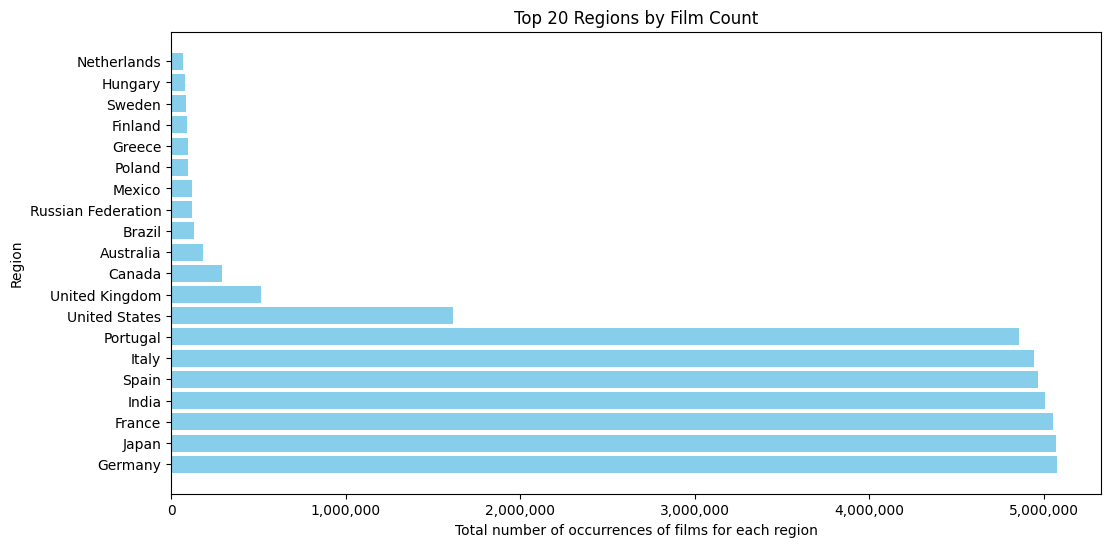

In [107]:

country_counts = df_with_countries.groupBy("country").count()
plot_film_stats_by_country(country_counts, "Total number of occurrences of films for each region")

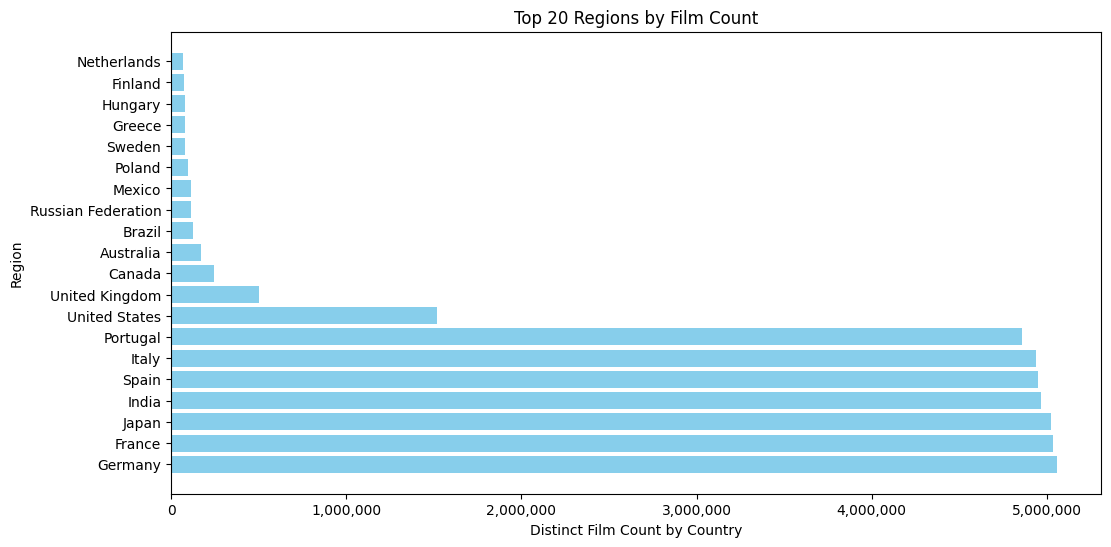

In [132]:
from pyspark.sql.functions import countDistinct
country_counts = df_with_countries.groupBy("country").agg(countDistinct("titleId").alias("count"))
plot_film_stats_by_country(country_counts, "Distinct Film Count by Country")

Check top 5 most frequent titles:

In [95]:
top_titles = df.groupBy("title").count().orderBy("count", ascending=False).limit(5)
top_titles.show()

+-------------+------+
|        title| count|
+-------------+------+
|Episodio #1.1|108703|
|Episodio #1.2| 98364|
|Episodio #1.3| 93063|
|Episodio #1.4| 86374|
|Episodio #1.5| 79252|
+-------------+------+



Count the number of films by country and language:

In [114]:
language_counts_per_region = df_with_countries.filter(col("language") != "Unknown").groupBy("country", "language").count().orderBy("count", ascending=False)
language_counts_per_region.show()

+------------+--------+-------+
|     country|language|  count|
+------------+--------+-------+
|       Japan|      ja|4921082|
|       India|      hi|4827985|
|      France|      fr|4790058|
|       Spain|      es|4790029|
|     Germany|      de|4790016|
|       Italy|      it|4790009|
|    Portugal|      pt|4789959|
|         XWW|      en| 196623|
|      Canada|      en| 117452|
|       India|      en|  73409|
|      Canada|      fr|  57952|
|     Türkiye|      tr|  39350|
|        SUHH|      ru|  38261|
|       China|     cmn|  37552|
| Philippines|      en|  31563|
|   Singapore|      en|  29465|
|    Bulgaria|      bg|  27208|
|South Africa|      en|  26087|
|   Hong Kong|      en|  16793|
|   Indonesia|      en|  14304|
+------------+--------+-------+
only showing top 20 rows



In [143]:
# df_with_countries = df_with_countries.drop("attributes", "types")
df_with_countries.show(10)

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
+---------+--------+--------------------+-------+--------+---------------+------------------+
|  titleId|ordering|               title| region|language|isOriginalTitle|           country|
+---------+--------+--------------------+-------+--------+---------------+------------------+
|tt0000001|       1|          Carmencita|Unknown| Unknown|              1|           Unknown|
|tt0000001|       2|          Carmencita|     DE| Unknown|              0|           Germany|
|tt0000001|       3|          Carmencita|     US| Unknown|              0|     United States|
|tt0000001|       4|Carmencita - span...|     HU| Unknown|              0|           Hungary|
|tt0000001|       5|          Καρμενσίτα|     GR| Unknown|              0|            Greece|
|tt0000001|       6|          Карменсита|     RU| Unknown|              0|Russian Federation|
|tt00000

In [145]:
temp_dir = "temp/title_akas_cleaned"
df_with_countries.coalesce(1).write.option("delimiter", "\t") \
    .option("header", "true") \
    .mode("overwrite") \
    .csv(temp_dir)

Business questions:
1. Which regions have the highest number of original titles (isOriginalTitle = 1) in the last 5 years? (Filter tables 'title.akas' by isOriginalTitle and 'title.basics' by startYear)<br>

*updated, relies on startYear in title.basics*<br>
**Which regions have the highest number of original titles in the last 5 years, and how do these titles correlate with their average ratings? (can also include the min, max, and standard deviation of ratings)**

| region | num_original_titles | avg_rating |
|--------|---------------------|------------|
| US     | 120                 | 7.3        |
| FR     | 90                  | 6.8        |
| DE     | 70                  | 7.1        |
| ES     | 50                  | 6.5        |

Answers like<br>
The US leads in the number of original titles, and the titles in the US also have the highest average ratings.<br>
Spain has the least number of original titles among the regions listed, with only 50 titles. The average rating of 6.5 is the lowest.<br>
The number of original titles in Germany is fewer than in the US and France, but the ratings are still high and similar to those in the US.<br>

2. Which languages have the most titles for a specific region and time period? (Filter tables 'title.akas' by region and 'title.basics' specific time frames)

*updated, relies on startYear in title.basics*<br>
**What are the most successful (highest-rated) titles in the past year created by recently active directors and writers? (title.ratings: tconst, averageRating; title.basics: tconst, primaryTitle, startYear; title.principals: tconst, nconst, category)**<br>

| title     | director_name | avg_rating | release_year |
|-----------|---------------|------------|--------------|
| Movie A   | Director A    | 8.9        | 2024         |
| Movie B   | Director B    | 8.5        | 2024         |
| Movie C   | Director A    | 8.2        | 2024         |
| Movie D   | Director C    | 8.0        | 2024         |

Answers like<br>
Movie A, directed by Director A, with a high rating of 8.9.<br>
Movie B, directed by Director B, with a rating of 8.5.<br>
3. **Which actors are most frequently associated with high-rated films across multiple regions, and how do their appearances vary by region? (Join 'title.akas' with 'title.ratings' to get region-specific films, and then join with 'title.principals' to find the actors involved)**<br>

| actor_name | region | appearances |
|------------|--------|-------------|
| Actor A    | US     | 15          |
| Actor B    | FR     | 12          |
| Actor A    | FR     | 10          |
| Actor C    | DE     | 8           |
| Actor B    | US     | 7           |
| Actor D    | US     | 5           |
| Actor A    | DE     | 4           |
| Actor E    | FR     | 3           |

Answers like<br>
Actor A appears the most in high-rated films in multiple regions, with a significant number of appearances in both the US and FR.

4. Which regions have the most alternative titles for films? (Group the titles by region and count how many alternative titles exist for each region)<br>
5. How has the average rating of films in each region changed over the last 10 years compared to the regional average? (Join the 'title.akas' table with the 'title.ratings' table on titleId to get the ratings of films for each region. The use the window function to partition by region and time to get the regional average rating for each region over time.)<br>

*updated, relies on startYear in title.basics*<br>
Compare based on languages:<br>
**How has the average rating of films in each language (based on original titles) changed over the last 5 years compared to the all-time average rating for that language? (title.basics: tconst, startYear, genres; title.ratings: tconst, averageRating; title.akas: titleId, isOriginalTitle, language)**

| Language | Avg Rating (Last 5 Years) | Avg Rating (All Time) | Rating Difference |
|----------|---------------------------|-----------------------|-------------------|
| English  | 7.5                       | 6.8                   | 0.7               |
| Spanish  | 8.1                       | 8.0                   | 0.1               |
| French   | 6.4                       | 6.9                   | -0.5              |


6. Which film titles have the most changes in regional names? (Group titles by titleId in 'title.akas' and count distinct alternative names by region)<br>

*updated*<br>
**Is there a pattern between the original language of a movie and its translation count in specific regions? (title.basics: tconst, originalTitle;
title.akas: titleId, region, language, isOriginalTitle)**

| original_title | region | num_translations | original_language |
|----------------|--------|------------------|-------------------|
| Movie A        | US     | 10               | English           |
| Movie A        | FR     | 7                | English           |
| Movie B        | US     | 5                | Spanish           |
| Movie B        | DE     | 4                | Spanish           |
| Movie C        | FR     | 6                | French            |

Answers like
Movies in English (e.g., Movie A) tend to have higher translation counts in regions like the US and France.
Movies in Spanish (e.g., Movie B) are more regionally specific.
Movies in French (e.g., Movie C) are localized more within French-speaking regions (like France), with fewer translations outside of these areas